Helmholtz Equation
===

The Holmholtz equation or frequency domain wave equation is

$$
-\Delta u - \omega^2 u = f
$$

we consider Dirichlet ("hard") boundary conditions 

$$
u(x) = 0 
$$

and Robin ("absorbing") boundary conditions

$$
\frac{\partial u}{\partial n} - i \omega u = 0 \qquad \text{ on } \Gamma_R
$$

The weak form is 

$$
\int_\Omega \nabla u \nabla v - \omega^2 u v - i \omega \int_{\Gamma_R} u v = \int_\Omega f v
$$

In [94]:
from ngsolve import *
from ngsolve.webgui import Draw
from math import pi
import numpy as np
from scipy.sparse import csr_matrix

In [95]:
f = 80
omega = 2*pi*f
h = 1/(5*f)
print(omega*h)

1.2566370614359172


使用 `VoxelCoefficient` 从numpy数组导入速度场

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# slowness model
def get_linear_model(top, bottom, n):
    if len(n) == 2:
        rho2 = np.linspace(top, bottom, n[1])
        rho1 = np.ones(n[0], dtype=float)
        rho = np.outer(rho1, rho2)
    else:
        rho_t = np.linspace(top, bottom, n[2])
        rho = np.ones(tuple(n), dtype=float)
        for k in range(n[2]):
            rho[:, :, k] *= rho_t[k]
    return np.rot90(rho,k=-1)

def get_wedge_model(n):
    h = 1.0 / (np.array(n) - 1)
    x = np.linspace(0, 1, n[0])
    y = np.linspace(0, 1, n[1])

    X = np.outer(x, np.ones(n[1], dtype=float))
    Y = np.outer(np.ones(n[0], dtype=float), y)
    Z = 0.25 * (np.tanh((4 * Y - X - 0.75) * 20)) + 0.75
    Z[:, n[1] // 2:] = Z[:, n[1] // 2 - 1::-1]
    return np.rot90(Z ** 2)

def wave_guide_model(n):
    h = 1.0 / (np.array(n) - 1)
    x = np.linspace(0, 1, n[0])
    y = np.linspace(0, 1, n[1])

    X = np.outer(x, np.ones(n[1], dtype=float))
    Y = np.outer(np.ones(n[0], dtype=float), y)
    Z = 1.25 * (1 - 0.4 * np.exp(-32 * np.abs(X - 0.5) ** 2))
    return np.rot90(1.0 / (Z ** 2))

def get_smooth_gaussian_medium(n):
    h = 1.0 / (np.array(n) - 1)
    src_kappa = np.array([n[0] // 2, n[1] // 2])
    xsrc = (src_kappa - 1) * h

    X1, X2 = np.meshgrid(np.arange(n[0]) * h[0], np.arange(n[1]) * h[1], indexing="ij")
    kappa_squared = np.exp(-4 * (X1 - xsrc[0]) ** 2 - 8 * (X2 - xsrc[1]) ** 2)
    return np.rot90(kappa_squared)

/var/folders/yh/r58scsg92jsgknskw__6w78c0000gn/T/ipykernel_17323/2837337678.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N = np.int(1/h)
/var/folders/yh/r58scsg92jsgknskw__6w78c0000gn/T/ipykernel_17323/2837337678.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


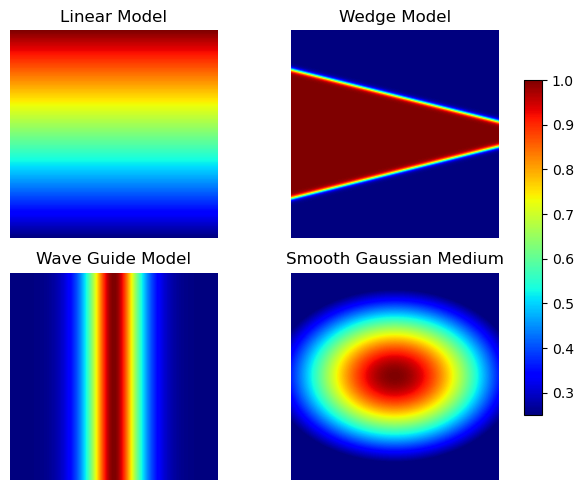

In [97]:
# 设置数组大小, 导入 NGSolve 时会线性插值到网格上
N = np.int(1/h)
n = [N, N] 

# 生成数据
linear_model = get_linear_model(0.25, 1, n)
wedge_model = get_wedge_model(n)
wave_guide = wave_guide_model(n)
smooth_gaussian = get_smooth_gaussian_medium(n)

fig, axs = plt.subplots(2, 2, figsize=(6,5))
cmap = 'jet'

# 设定颜色映射的最小值和最大值
vmin = 0.25
vmax = 1

# 绘制 Linear Model
im1 = axs[0, 0].imshow(linear_model, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[0, 0].set_title("Linear Model")
axs[0, 0].axis('off')

# 绘制 Wedge Model
im2 = axs[0, 1].imshow(wedge_model, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[0, 1].set_title("Wedge Model")
axs[0, 1].axis('off')

# 绘制 Wave Guide Model
im3 = axs[1, 0].imshow(wave_guide, cmap=cmap, origin='lower')
axs[1, 0].set_title("Wave Guide Model")
axs[1, 0].axis('off')

# 绘制 Smooth Gaussian Medium
im4 = axs[1, 1].imshow(smooth_gaussian, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
axs[1, 1].set_title("Smooth Gaussian Medium")
axs[1, 1].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.95, 0.16, 0.03, 0.67])  
fig.colorbar(im1, cax=cbar_ax)

plt.tight_layout()
plt.show()

In [98]:
help(VoxelCoefficient)

Help on built-in function VoxelCoefficient in module ngsolve.fem:

VoxelCoefficient(...) method of builtins.PyCapsule instance
    VoxelCoefficient(start: tuple, end: tuple, values: numpy.ndarray, linear: bool = True, trafocf: object = <ngsolve.ngstd.DummyArgument>) -> ngsolve.fem.CoefficientFunction
    
    CoefficientFunction defined on a grid.
    
    Start and end mark the cartesian boundary of domain. The function will be continued by a constant function outside of this box. Inside a cartesian grid will be created by the dimensions of the numpy input array 'values'. This array must have the dimensions of the mesh and the values stored as:
    x1y1z1, x2y1z1, ..., xNy1z1, x1y2z1, ...
    
    If linear is True the function will be interpolated linearly between the values. Otherwise the nearest voxel value is taken.



In [99]:
mesh = Mesh(unit_square.GenerateMesh(maxh=h))

slowness = VoxelCoefficient((0,0), (1,1), linear_model.astype(np.complex128), linear=False)
fes = H1(mesh, order=3, complex=True)
print ("number of dofs =", fes.ndof)
s = GridFunction(fes)
s.Set(slowness)

# Draw(s, mesh, "func")

number of dofs = 1667653


In [100]:
u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm(fes)
a += (grad(u)*grad(v)-omega**2*s**2*u*v)*dx
a += -1j*omega*u*v*ds
a.Assemble()

In [101]:
source = (1/h**2)*exp(-(300**2)*((x-0.5)**2 + (y-0.98)**2))
# Draw(source, mesh, order=3)

In [102]:
f = LinearForm(source*v*dx).Assemble()

In [107]:
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(inverse="umfpack") * f.vec

In [109]:
Draw(gfu, mesh, order=3)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

BaseWebGuiScene

In [105]:
help(a.mat.Inverse) 

Help on method Inverse in module ngsolve.la:

Inverse(...) method of ngsolve.la.SparseMatrixNSt3__17complexIdEE instance
    Inverse(self: ngsolve.la.BaseMatrix, freedofs: pyngcore.pyngcore.BitArray = None, inverse: Optional[str] = None, flags: pyngcore.pyngcore.Flags = <pyngcore.pyngcore.Flags object at 0x114c265b0>) -> BaseMatrix
    
    Calculate inverse of sparse matrix
    Parameters:
    
    freedofs : BitArray
      If set, invert only the rows/columns the matrix defined by the bit array, otherwise invert the whole matrix
    
    inverse : string
      Solver to use, allowed values are:
        sparsecholesky - internal solver of NGSolve for symmetric matrices
        umfpack        - solver by Suitesparse/UMFPACK (if NGSolve was configured with USE_UMFPACK=ON)
        pardiso        - PARDISO, either provided by libpardiso (USE_PARDISO=ON) or Intel MKL (USE_MKL=ON).
                         If neither Pardiso nor Intel MKL was linked at compile-time, NGSolve will look
      

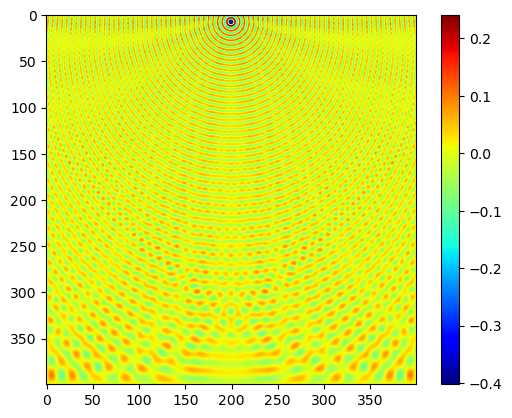

In [108]:
import matplotlib.pyplot as plt
X = np.linspace(0, 1, N)
u = np.zeros((N,N))
for i in range(N):
    Y = np.ones_like(X) * X[i]
    u[:,i] = gfu(mesh(X, Y))[:,0].real
plt.imshow(np.rot90(u), cmap="jet")
plt.colorbar()